# Technical analysis

In [5]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from datetime import date
from dateutil.relativedelta import relativedelta

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [7]:
covid_crash = '2020-02-19'
initial_date = (date.fromisoformat(covid_crash) - relativedelta(years=1)).strftime("%Y-%m-%d")

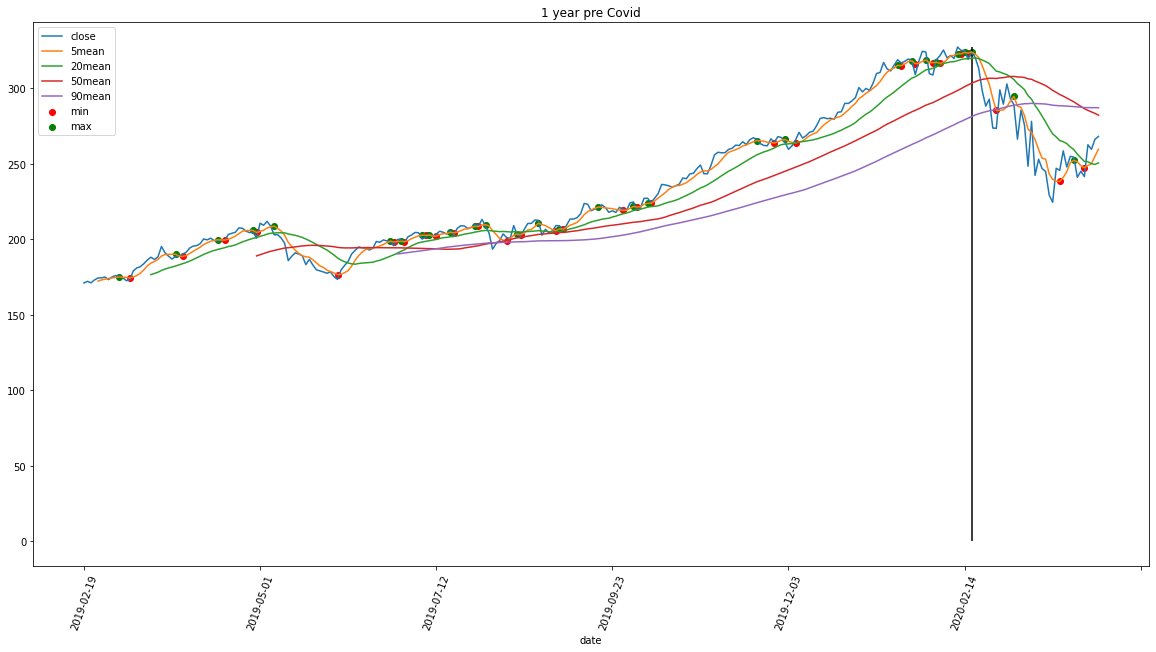

In [8]:
# companies = ['AAPL','FB','GOOG','F','TSLA']
companies = ['AAPL']
listofdf = []
for item in companies:
    histprices = requests.get(f"https://financialmodelingprep.com/api/v3/historical-price-full/{item}?serietype=line&from={initial_date}")
    histprices = histprices.json()

    #Parse the API response and select only last 600 days of prices
    #histprices = histprices['historical'][-600:]
    histprices = histprices['historical']
    #Convert from dict to pandas datafram
    histpricesdf = pd.DataFrame.from_dict(histprices)
    #rename column
    # histpricesdf = histpricesdf.rename({'close': item}, axis=1)
    #append all dfs to list
    listofdf.append(histpricesdf)
#set index of each DataFrame by common column before concatinating them
dfs = [df.set_index('date') for df in listofdf]
for df in dfs:
    df['5mean'] = df['close'].rolling(5).mean()
    df['20mean'] = df['close'].rolling(20).mean()
    df['50mean'] = df['close'].rolling(50).mean()
    df['90mean'] = df['close'].rolling(90).mean()
    df['min'] = df['5mean'][(df['5mean'].shift(1) > df['5mean']) & (df['5mean'].shift(-1) > df['5mean'])]
    df['max'] = df['5mean'][(df['5mean'].shift(1) < df['5mean']) & (df['5mean'].shift(-1) < df['5mean'])]
    
histpriceconcat = pd.concat(dfs,axis=1)
#set_trace()
#divide all dataframe by first line of data to enable comparison
#histpriceconcat = histpriceconcat/histpriceconcat.iloc[0]

#for i, col in enumerate(histpriceconcat.columns):
plt.title('1 year pre Covid')

histpriceconcat['close'].plot()
histpriceconcat['5mean'].plot()
histpriceconcat['20mean'].plot()
histpriceconcat['50mean'].plot()
histpriceconcat['90mean'].plot()

plt.scatter(histpriceconcat.index, histpriceconcat['min'], c='r')
plt.scatter(histpriceconcat.index, histpriceconcat['max'], c='g')

plt.xticks(rotation=70)
plt.legend(histpriceconcat.columns)
plt.vlines(covid_crash, 0, max(histpriceconcat['close']))


In [29]:
bottom = min(histpriceconcat[covid_crash:]['close'])
top = max(histpriceconcat[covid_crash:]['close'])
curr = histpriceconcat['close'][-1]
print(top)
print(bottom)
print(curr)

323.62
224.37
267.99


In [28]:
potential_gain = ((top - curr)/curr) * 100
potential_loss = ((bottom - curr)/curr) * 100
print(potential_gain)
print(potential_loss)

20.758237247658492
-16.276726743535207
